In [96]:
import matplotlib

# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data.dataloader import default_collate

from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [44]:
DATA_DIR = "../Lernnavi"  # You many change the directory

users = pd.read_csv("{}/users.csv.gz".format(DATA_DIR))
events = pd.read_csv("{}/study/events.csv.gz".format(DATA_DIR))
transactions = pd.read_csv("{}/study/transactions.csv.gz".format(DATA_DIR))
documents = pd.read_csv("{}/documents.csv.gz".format(DATA_DIR))
topics_translated = pd.read_csv("{}/topics_translated.csv".format(DATA_DIR))
topic_trees = pd.read_csv("{}/topic_trees.csv.gz".format(DATA_DIR))
feedback = pd.read_csv("{}/feedback.csv.gz".format(DATA_DIR))


# Data preprocessing


In [45]:
def extract_features(
    users, events, transactions, documents, topics_translated, topic_trees
):
    users_df = users[["user_id"]]
    # drop user_id NA
    users_df = users_df.dropna(subset=["user_id"])
    events_df = events[
        [
            "user_id",
            "transaction_token",
            "category",
            "action",
            "event_type",
            "session_id",
            "session_closed",
            "session_type",
            "session_accepted",
        ]
    ]
    transactions_df = transactions[
        [
            "transaction_token",
            "document_id",
            "document_version",
            "evaluation",
            "start_time",
            "commit_time",
            "type",
            "topic_id",
            "challenge",
        ]
    ]
    document_df = documents[
        ["document_id", "version", "created_time", "author_id", "status"]
    ]
    document_df = document_df.rename(columns={"version": "document_version"})
    topics_translated_df = topics_translated[["id", "german_name", "math"]]
    topics_translated_df = topics_translated_df.rename(
        columns={"id": "topic_id", "german_name": "topic_name"}
    )
    topic_trees_df = topic_trees[["topic_id", "sibling_rank", "displayed_on_dashboard"]]

    # merge the dataframes
    df = pd.merge(transactions_df, events_df, on="transaction_token", how="left")
    df = pd.merge(df, document_df, on=["document_id", "document_version"], how="left")
    df = pd.merge(df, topics_translated_df, on="topic_id", how="left")
    df = pd.merge(df, topic_trees_df, on="topic_id", how="left")
    df = pd.merge(df, users_df, on="user_id", how="left")

    df["start_time"] = pd.to_datetime(df["start_time"])
    df["commit_time"] = pd.to_datetime(df["commit_time"])
    df["created_time"] = pd.to_datetime(df["created_time"])

    df["time_took"] = df["commit_time"] - df["start_time"]
    df["time_took"].fillna(pd.Timedelta(seconds=0), inplace=True)
    df["week"] = df["start_time"].dt.isocalendar().week
    df["week"] = df["week"] - df["week"].min()

    year = df["start_time"].dt.year
    assert year.unique().size == 1

    # drop transaction_token and document_id and document_version
    df = df.drop(
        [
            "transaction_token",
            "document_id",
            "document_version",
            "topic_id",
            "session_id",
            "author_id",
        ],
        axis=1,
    )

    return df


In [46]:
def extract_features_from_categorical_data(X):
    X = X.copy()

    X["time_took"] = X["time_took"].astype("int64") // 10**9

    for column in X.columns:
        if X[column].dtype == "object" or X[column].dtype == "bool":
            dummy = pd.get_dummies(X[column], prefix=column, dummy_na=True)
            X = pd.concat([X, dummy], axis=1)
            X = X.drop(column, axis=1)

    for column in X.columns:
        if not (
            "int" in str(X[column].dtype).lower()
            or "float" in str(X[column].dtype).lower()
        ):
            X = X.drop(column, axis=1)

    X["transactions"] = 1

    X.fillna(0, inplace=True)

    return X


In [47]:
def aggregate_data_by_user_week(categorical_data_set, users):
    data_set_by_user_week = categorical_data_set.groupby(["user_id", "week"]).sum()

    # for each user, pad data with zeros for weeks where no transactions were made
    data_set_by_user_week = data_set_by_user_week.unstack()
    data_set_by_user_week = data_set_by_user_week.fillna(0)
    data_set_by_user_week = data_set_by_user_week.stack()

    data_set_by_user_week = data_set_by_user_week.reset_index()
    data_set_by_user_week = data_set_by_user_week[data_set_by_user_week["user_id"] != 0]

    # add "gender", "canton", "class_level" from users
    return pd.merge(
        data_set_by_user_week,
        users[["user_id", "gender", "canton", "class_level"]],
        on="user_id",
        how="left",
    )


In [48]:
def get_data_preprocessor(X):
    X = X.drop("user_id", axis=1)

    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown="ignore")

    num_features = []
    cat_features = []

    for column in X.columns:
        if column == "user_id":
            continue

        if X[column].dtype == "object" or X[column].dtype == "bool":
            cat_features.append(column)
        else:
            num_features.append(column)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features),
        ],
        remainder="passthrough",
    )

    preprocessor.fit(X)

    return preprocessor


In [49]:
def split_data_set(
    data_set, train_ratio=0.7, validation_ratio=0.1, test_ratio=0.2, random_seed=42
):
    users = data_set.user_id.unique()

    users_train, users_test = train_test_split(
        users, test_size=1 - train_ratio, random_state=random_seed
    )

    users_validation, users_test = train_test_split(
        users_test, test_size=test_ratio / (test_ratio + validation_ratio), random_state=random_seed
    )

    data_train = data_set[data_set["user_id"].isin(users_train)]
    data_validation = data_set[data_set["user_id"].isin(users_validation)]
    data_test = data_set[data_set["user_id"].isin(users_test)]

    return data_train, data_validation, data_test


In [50]:
def prepare_X_Y(data, preprocessor, pred_column="transactions", window=4, ahead=1):
    data = data.sort_values(by=["user_id", "week"])
    data = [v.drop("user_id", axis=1) for _, v in data.groupby("user_id")]

    X = []
    Y = []

    for user_data in data:
        for i in range(window, len(user_data) + 1 - ahead):
            x = preprocessor.transform(user_data.iloc[i - window : i + ahead - 1])
            y = user_data.iloc[i - window + 1 : i + ahead][pred_column].to_numpy()

            X.append(x)
            Y.append(y)

    return np.array(X), Y


In [51]:
data_set = extract_features(
    users, events, transactions, documents, topics_translated, topic_trees
)

In [52]:
categorical_data_set = extract_features_from_categorical_data(data_set)

In [53]:
week_activity_user = aggregate_data_by_user_week(categorical_data_set, users)

# Data visualization


In [54]:
week_activity_user.head(n=15)

,user_id,week,session_closed,session_type,session_accepted,math,sibling_rank,displayed_on_dashboard,time_took,evaluation_CORRECT,...,topic_name_Wortschatz,topic_name_Wurzelgleichungen,topic_name_Wurzeln,topic_name_Zahlenmengen,topic_name_Zentrische Streckung und Ähnlichkeit,topic_name_nan,transactions,gender,canton,class_level
0,387711.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FEMALE,SG,Gymnasium - 2. Jahr
1,387711.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FEMALE,SG,Gymnasium - 2. Jahr
2,387711.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FEMALE,SG,Gymnasium - 2. Jahr
3,387711.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,24.0,FEMALE,SG,Gymnasium - 2. Jahr
4,387711.0,4,0.0,0.0,0.0,0.0,0.0,0.0,3735.0,18.0,...,0.0,0.0,0.0,0.0,0.0,24.0,24.0,FEMALE,SG,Gymnasium - 2. Jahr
5,387711.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FEMALE,SG,Gymnasium - 2. Jahr
6,387711.0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,FEMALE,SG,Gymnasium - 2. Jahr
7,387711.0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FEMALE,SG,Gymnasium - 2. Jahr
8,387711.0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FEMALE,SG,Gymnasium - 2. Jahr
9,387711.0,9,0.0,0.0,0.0,0.0,0.0,0.0,18315.0,84.0,...,0.0,0.0,0.0,0.0,0.0,108.0,108.0,FEMALE,SG,Gymnasium - 2. Jahr


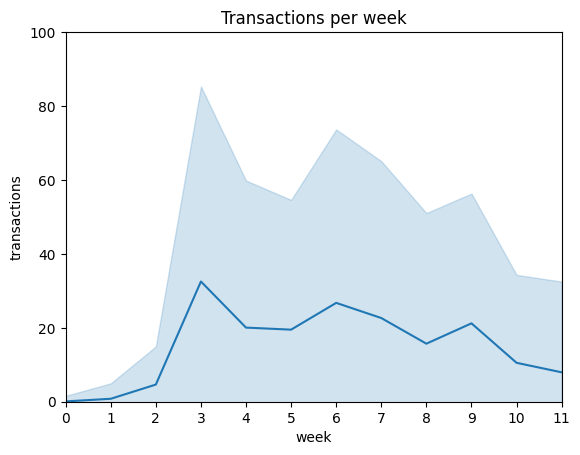

In [55]:
# convert week to float
week_activity_user["week"] = week_activity_user["week"].astype("float64")

ax = sns.lineplot(data=week_activity_user, x="week", y="transactions", errorbar="sd")
ax.set_xlim(0, 11)
ax.set_ylim(0, 100)
plt.xticks(range(12))
plt.title("Transactions per week")
plt.show()

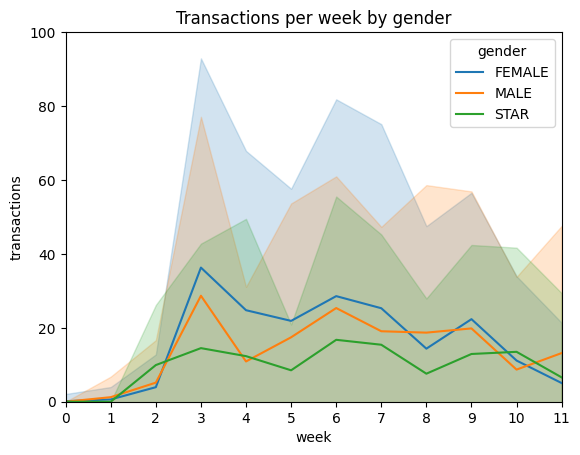

In [56]:
ax = sns.lineplot(
    data=week_activity_user, x="week", y="transactions", errorbar="sd", hue="gender"
)
ax.set_xlim(0, 11)
ax.set_ylim(0, 100)
plt.xticks(range(12))
plt.title("Transactions per week by gender")
plt.show()


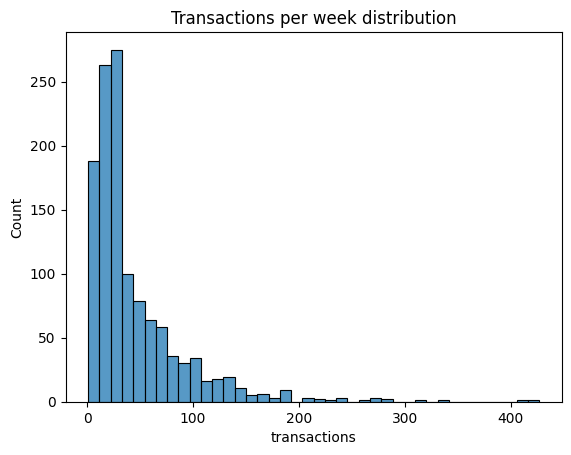

In [57]:
sns.histplot(
    data=week_activity_user[week_activity_user["transactions"] > 0],
    x="transactions",
    bins=40,
)
plt.title("Transactions per week distribution")
plt.show()

In [58]:
# classify engagement using transaction/mean ratio, exponential scale
def get_labels_exp(data):
  label = data[["user_id", "week", "transactions"]]
  avg = label.copy()
  avg = avg.groupby("week")["transactions"].mean().reset_index(name="mean")
  label = pd.merge(label, avg, on='week')
  label["engagement_t"] = label["transactions"]/label["mean"]
  #label = label[label.week > 0]
  label["engagement"] = 6
  label.loc[label.engagement_t < 8,["engagement"]] = 5
  label.loc[label.engagement_t < 4,["engagement"]] = 4
  label.loc[label.engagement_t < 2,["engagement"]] = 3
  label.loc[label.engagement_t < 1,["engagement"]] = 2
  label.loc[label.engagement_t < 0.5,["engagement"]] = 1
  label.loc[label.engagement_t == 0,["engagement"]] = 0
  label = label[["user_id", "week", "engagement"]]

  return label
  
# classify engagement inspired by normal distribution
def get_labels_nrm(data):
  label = data[["user_id", "week", "transactions"]]
  avg = label.copy()
  avg = avg.groupby("week")["transactions"].mean().reset_index(name="mean")
  std = label.copy()
  std = std.groupby("week")["transactions"].std().reset_index(name="std")
  label = pd.merge(label, avg, on='week')
  label = pd.merge(label, std, on='week')
  #label = label[label.week > 0]
  label["engagement"] = 5
  label.loc[label["transactions"] < label["mean"]+2*label["std"],["engagement"]] = 4
  label.loc[label["transactions"] < label["mean"]+label["std"],["engagement"]] = 3
  label.loc[label["transactions"] < label["mean"],["engagement"]] = 2
  label.loc[label["transactions"] < label["mean"]-label["std"],["engagement"]] = 1
  label.loc[label["transactions"] < label["mean"]-2*label["std"],["engagement"]] = 0
  label.loc[label.transactions == 0, ["engagement"]] = 0
  label = label[["user_id", "week", "engagement"]]

  return label

# classify engagement using quantiles (omit 0 transactions row)
def get_labels_qt(data):
  label = data[["user_id", "week", "transactions"]]
  qt02 = label[label['transactions'] != 0]
  qt02 = qt02.groupby("week")["transactions"].quantile(0.2).reset_index(name="qt02")
  qt04 = label[label['transactions'] != 0]
  qt04 = qt04.groupby("week")["transactions"].quantile(0.4).reset_index(name="qt04")
  qt06 = label[label['transactions'] != 0]
  qt06 = qt06.groupby("week")["transactions"].quantile(0.6).reset_index(name="qt06")
  qt08 = label[label['transactions'] != 0]
  qt08 = qt08.groupby("week")["transactions"].quantile(0.8).reset_index(name="qt08")
  label = pd.merge(label, qt02, on='week')
  label = pd.merge(label, qt04, on='week')
  label = pd.merge(label, qt06, on='week')
  label = pd.merge(label, qt08, on='week')
  #label = label[label.week > 0]
  label["engagement"] = 5
  label.loc[label["transactions"] < label["qt08"],["engagement"]] = 4
  label.loc[label["transactions"] < label["qt06"],["engagement"]] = 3
  label.loc[label["transactions"] < label["qt04"],["engagement"]] = 2
  label.loc[label["transactions"] < label["qt02"],["engagement"]] = 1
  label.loc[label.transactions == 0, ["engagement"]] = 0
  label = label[["user_id", "week", "engagement"]]

  return label

def merge_data_w_labels(data, label):
  week_activity_user_w_labels = pd.merge(data, label, on=["user_id", "week"])
  return week_activity_user_w_labels

def merge_data_w_labels_n_shift(data, label):
  week_activity_user_w_labels = pd.merge(data, label, on=["user_id", "week"])
  week_activity_user_w_labels = week_activity_user_w_labels[week_activity_user_w_labels.week < 11]
  next_label = label[label.week > 0]
  next_label["week"] -= 1
  next_label = next_label.rename(columns={"engagement": "next_engagement"})
  week_activity_user_w_labels = pd.merge(week_activity_user_w_labels, next_label, on=["user_id", "week"])

  return week_activity_user_w_labels
  
def shift_transactions(data):
  week_activity_user_w_labels = data.copy()
  week_activity_user_w_labels = week_activity_user_w_labels[week_activity_user_w_labels.week < 11]
  label = week_activity_user_w_labels[["user_id", "week", "transactions"]]
  next_label = label[label.week > 0]
  next_label["week"] -= 1
  next_label = next_label.rename(columns={"transactions": "next_engagement"})
  week_activity_user_w_labels = pd.merge(week_activity_user_w_labels, next_label, on=["user_id", "week"])

  return week_activity_user_w_labels

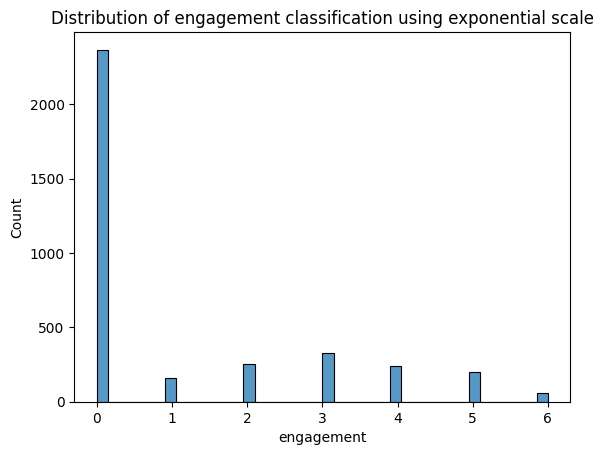

In [59]:
label_exp = get_labels_exp(week_activity_user)

sns.histplot(
    data=label_exp,
    x="engagement",
    bins=40,
)
plt.title("Distribution of engagement classification using exponential scale")
plt.show()

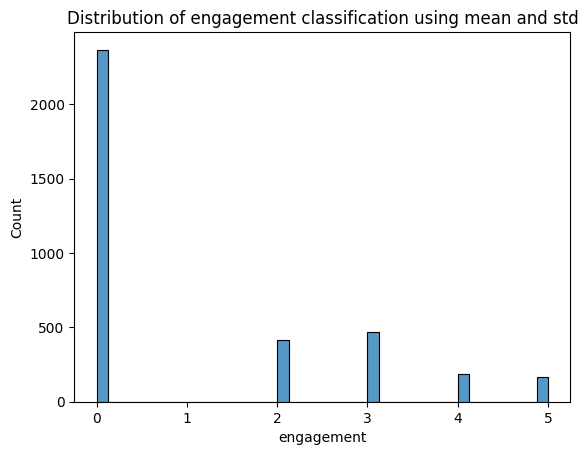

In [60]:
label_nrm = get_labels_nrm(week_activity_user)

sns.histplot(
    data=label_nrm,
    x="engagement",
    bins=40,
)
plt.title("Distribution of engagement classification using mean and std")
plt.show()

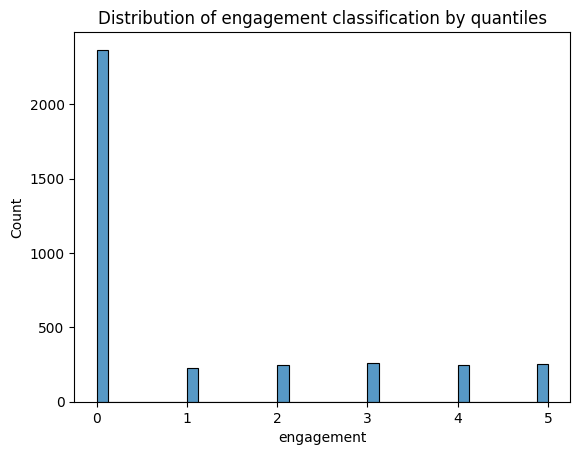

In [61]:
label_qt = get_labels_qt(week_activity_user)

sns.histplot(
    data=label_qt,
    x="engagement",
    bins=40,
)
plt.title("Distribution of engagement classification by quantiles")
plt.show()

# Models


## sktime

### Training

In [72]:
label = label_exp
week_activity_user_classified = merge_data_w_labels_n_shift(week_activity_user, label)

data_train, data_validation, data_test = split_data_set(week_activity_user_classified)
preprocessor = get_data_preprocessor(week_activity_user_classified)

pred_column = "engagement"  # if classified

tsforest_classifier = TimeSeriesForestClassifier()
tsforest_classifier.fit(preprocessor.transform(data_train), data_train["next_engagement"].values)

/var/folders/6x/3mrnnkqx4jj9vs2kqh6z638w0000gn/T/ipykernel_47571/2860755715.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_label["week"] -= 1


TimeSeriesForestClassifier()

### Evaluation

Accuracy: 0.9731743666169895
Balanced accuracy: 0.908700336513456
Confusion matrix:


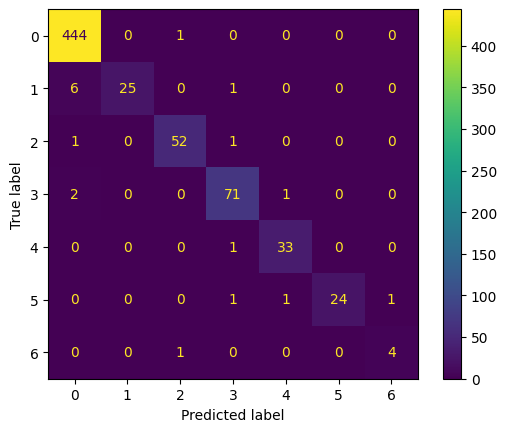

In [83]:
y_pred = tsforest_classifier.predict(preprocessor.transform(data_test))
print("Accuracy:", accuracy_score(data_test["next_engagement"].values, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(data_test["next_engagement"].values, y_pred))

print("Confusion matrix:")
cm = confusion_matrix(data_test["next_engagement"].values, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## LSTM - 1 week ahead

### Training


In [ ]:
data_train, data_validation, data_test = split_data_set(week_activity_user)
preprocessor = get_data_preprocessor(week_activity_user)

X_train, Y_train = prepare_X_Y(data_train, preprocessor, window=4, ahead=1)
X_test, Y_test = prepare_X_Y(data_test, preprocessor, window=4, ahead=1)
X_validation, Y_validation = prepare_X_Y(data_validation, preprocessor, window=4, ahead=1)

# Setup device
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

# Transform data to tensors
X_train = torch.tensor(X_train).float().to(device)
Y_train = torch.tensor(Y_train).float().unsqueeze(-1).to(device)
X_test = torch.tensor(X_test).float().to(device)
Y_test = torch.tensor(Y_test).float().unsqueeze(-1).to(device)
X_validation = torch.tensor(X_validation).float().to(device)
Y_validation = torch.tensor(Y_validation).float().unsqueeze(-1).to(device)

/var/folders/6x/3mrnnkqx4jj9vs2kqh6z638w0000gn/T/ipykernel_47571/3688703565.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678455016227/work/torch/csrc/utils/tensor_new.cpp:248.)
  Y_train = torch.tensor(Y_train).float().unsqueeze(-1).to(device)


In [ ]:
class UserEngagementLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = UserEngagementLSTM(X_train.size()[-1])
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()
loader = data.DataLoader(data.TensorDataset(X_train, Y_train), shuffle=True, batch_size=64, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [ ]:
model.to(device)

epochs = []
train_losses = []
validation_losses = []

n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_l1 = loss_fn(y_pred, Y_train)
        y_pred = model(X_validation)
        validation_l1 = loss_fn(y_pred, Y_validation)

        epochs.append(epoch)
        train_losses.append(train_l1)
        validation_losses.append(validation_l1)
    print("Epoch %d: train L1 %.4f, validation L1 %.4f" % (epoch, train_l1, validation_l1))

Epoch 0: train L1 20.3348, validation L1 17.8444
Epoch 10: train L1 16.3610, validation L1 16.5286
Epoch 20: train L1 12.9634, validation L1 15.2647
Epoch 30: train L1 11.1026, validation L1 15.4609
Epoch 40: train L1 10.2500, validation L1 15.1887
Epoch 50: train L1 8.9339, validation L1 14.5257
Epoch 60: train L1 8.3323, validation L1 13.9155
Epoch 70: train L1 7.9476, validation L1 14.3228
Epoch 80: train L1 7.4991, validation L1 13.9918
Epoch 90: train L1 7.3545, validation L1 13.7969
Epoch 100: train L1 7.0943, validation L1 13.9444
Epoch 110: train L1 6.9084, validation L1 13.8827
Epoch 120: train L1 6.6997, validation L1 14.1685
Epoch 130: train L1 6.6313, validation L1 13.9245
Epoch 140: train L1 6.4024, validation L1 13.7962
Epoch 150: train L1 6.4088, validation L1 14.2844
Epoch 160: train L1 6.1986, validation L1 13.7898
Epoch 170: train L1 6.1793, validation L1 13.7502
Epoch 180: train L1 5.9773, validation L1 13.9614
Epoch 190: train L1 5.9844, validation L1 13.8131
Epoch 

Text(0.5, 1.0, 'Train and validation L1 loss')

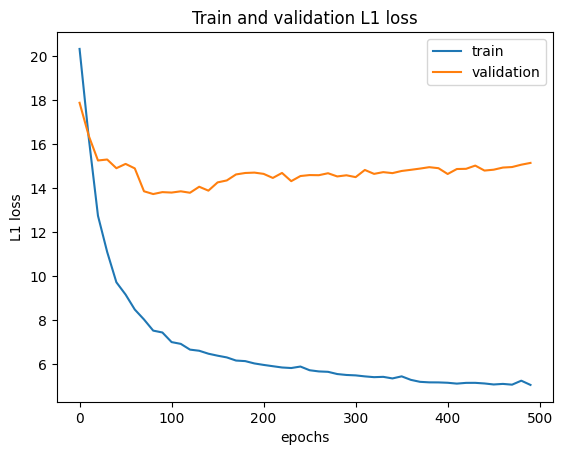

In [ ]:
# plot the losses using seaborn in the same plot

train_losses = [x.item() for x in train_losses]
validation_losses = [x.item() for x in validation_losses]

sns.lineplot(x=epochs, y=train_losses, label="train")
sns.lineplot(x=epochs, y=validation_losses, label="validation")

# label x as epochs
plt.xlabel("epochs")

# label y as L1
plt.ylabel("L1 loss")

plt.title("Train and validation L1 loss")

In [ ]:
# save model to file
torch.save(model.state_dict(), "model.pt")

In [ ]:
# load model from file
model = UserEngagementLSTM(X_train.size()[-1])
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

### Evaluation

In [ ]:
# predict on test data
model.eval()
model.to(device)

with torch.no_grad():
    y_pred = model(X_test)
    test_l1 = loss_fn(y_pred, Y_test)
    print("Test L1 loss %.4f" % test_l1)

y_test = Y_test.cpu().numpy()
x_test = X_test.cpu().numpy()

y = y_pred.cpu().numpy()

Test L1 loss 13.6100


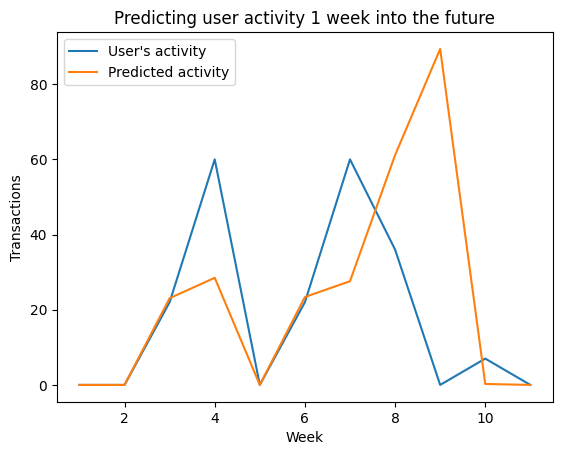

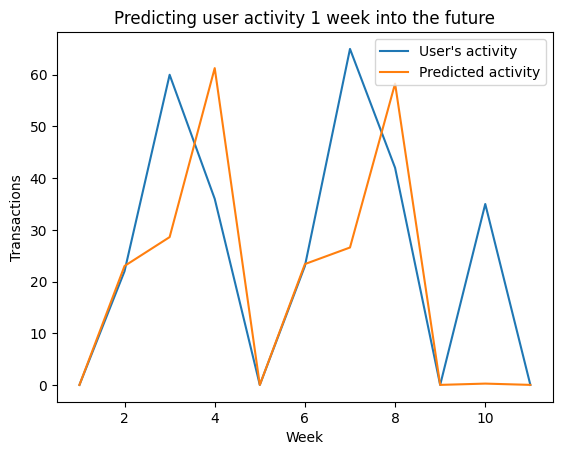

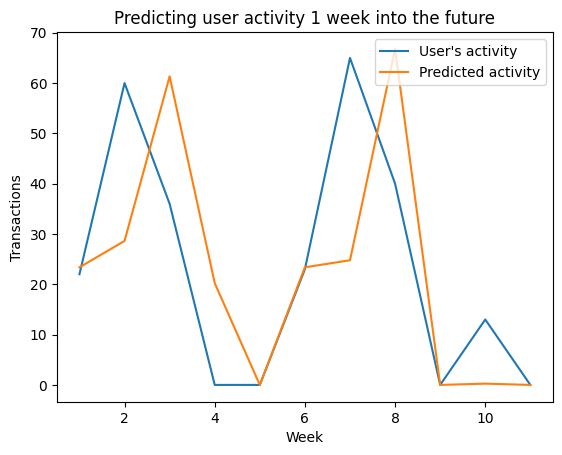

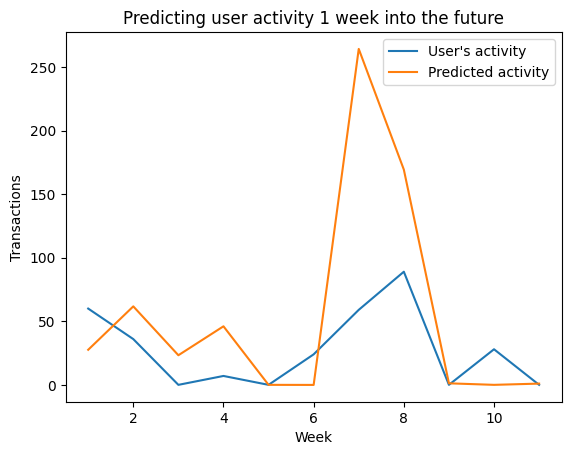

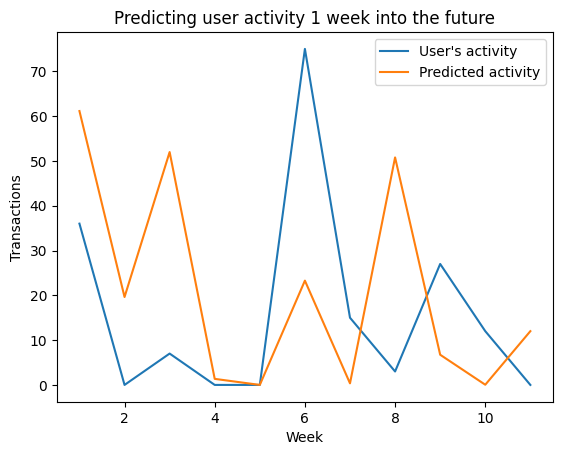

In [ ]:
for user in range(5):
    plt.figure()
    plt.title("Predicting user activity 1 week into the future")
    plt.xlabel("Week")
    plt.ylabel("Transactions")
    sns.lineplot(x=range(1, 12), y=np.concatenate([y_test[user].flatten(),[z[0][-1] for z in y_test[user*8+1:user*8+8]]]), label="User's activity")
    sns.lineplot(x=range(1, 12), y=np.concatenate([y[user].flatten(),[z[0][-1] for z in y[user*8+1:user*8+8]]]), label="Predicted activity")

    plt.plot()


## LSTM - 4 weeks ahead - regression

### Training

In [ ]:
data_train, data_validation, data_test = split_data_set(week_activity_user)
preprocessor = get_data_preprocessor(week_activity_user)

X_train, Y_train = prepare_X_Y(data_train, preprocessor, window=4, ahead=4)
X_test, Y_test = prepare_X_Y(data_test, preprocessor, window=4, ahead=4)
X_validation, Y_validation = prepare_X_Y(data_validation, preprocessor, window=4, ahead=4)

# Setup device
device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Transform data to tensors
X_train = torch.tensor(X_train).float().to(device)
Y_train = torch.tensor(Y_train).float().unsqueeze(-1).to(device)
X_test = torch.tensor(X_test).float().to(device)
Y_test = torch.tensor(Y_test).float().unsqueeze(-1).to(device)
X_validation = torch.tensor(X_validation).float().to(device)
Y_validation = torch.tensor(Y_validation).float().unsqueeze(-1).to(device)

model = UserEngagementLSTM(X_train.size()[-1], 128, 4)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, Y_train), shuffle=True, batch_size=32, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [ ]:
model.to(device)

epochs = []
train_losses = []
validation_losses = []

n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_mse = loss_fn(y_pred, Y_train)
        y_pred = model(X_validation)
        validation_mse = loss_fn(y_pred, Y_validation)

        epochs.append(epoch)
        train_losses.append(train_mse)
        validation_losses.append(validation_mse)
    print("Epoch %d: train MSE %.4f, validation MSE %.4f" % (epoch, train_mse, validation_mse))

Epoch 0: train MSE 1893.5599, validation MSE 1248.7317
Epoch 10: train MSE 1679.6857, validation MSE 1117.0726
Epoch 20: train MSE 1432.6343, validation MSE 915.7083
Epoch 30: train MSE 1004.2080, validation MSE 763.9859
Epoch 40: train MSE 821.6759, validation MSE 826.2628
Epoch 50: train MSE 678.6993, validation MSE 756.8267
Epoch 60: train MSE 589.8339, validation MSE 751.7568
Epoch 70: train MSE 509.2024, validation MSE 719.4869
Epoch 80: train MSE 457.3408, validation MSE 745.5854
Epoch 90: train MSE 416.1147, validation MSE 705.7846
Epoch 100: train MSE 372.5231, validation MSE 759.3927
Epoch 110: train MSE 352.1829, validation MSE 787.6841
Epoch 120: train MSE 329.0076, validation MSE 813.0054
Epoch 130: train MSE 294.3951, validation MSE 760.5446
Epoch 140: train MSE 277.8667, validation MSE 773.2618
Epoch 150: train MSE 265.7036, validation MSE 764.5724
Epoch 160: train MSE 275.4309, validation MSE 703.6511
Epoch 170: train MSE 246.5848, validation MSE 727.5885
Epoch 180: trai

Text(0.5, 1.0, 'Train and validation MSE loss')

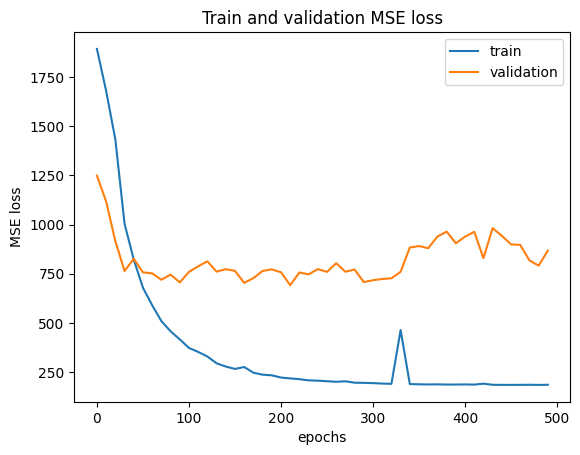

In [ ]:
# plot the losses using seaborn in the same plot

train_losses = [x.item() for x in train_losses]
validation_losses = [x.item() for x in validation_losses]

sns.lineplot(x=epochs, y=train_losses, label="train")
sns.lineplot(x=epochs, y=validation_losses, label="validation")

# label x as epochs
plt.xlabel("epochs")

plt.ylabel("MSE loss")

plt.title("Train and validation MSE loss")

In [ ]:
# save model to file
torch.save(model.state_dict(), "model4.pt")

In [ ]:
# load model from file
model = UserEngagementLSTM(X_train.size()[-1])
model.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

### Evaluation

In [ ]:
# predict on test data
model.eval()
model.to(device)

with torch.no_grad():
    y_pred = model(X_test)
    test_l1 = loss_fn(y_pred, Y_test)
    print("Test MSE loss %.4f" % test_l1)

y_test = Y_test.cpu().numpy()
x_test = X_test.cpu().numpy()

y = y_pred.cpu().numpy()

Test MSE loss 921.4429


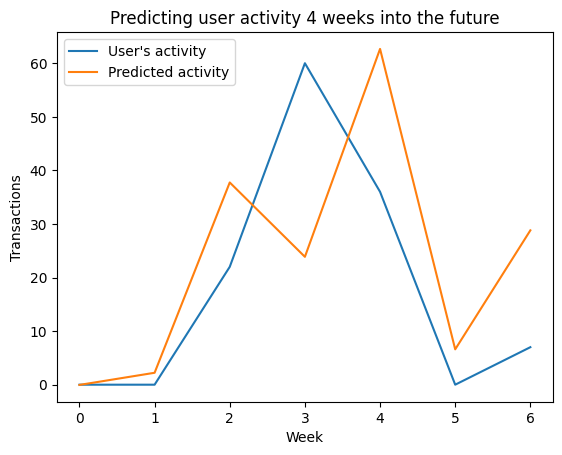

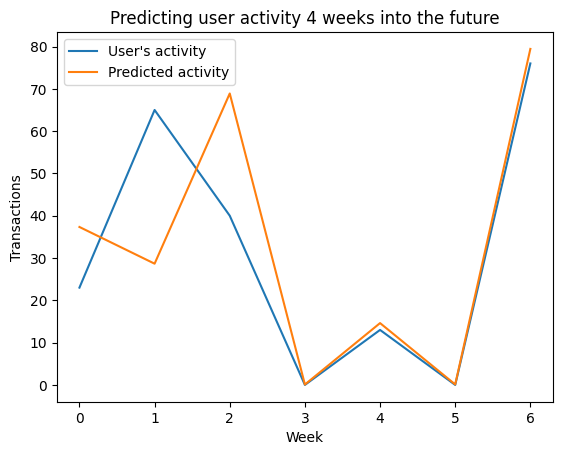

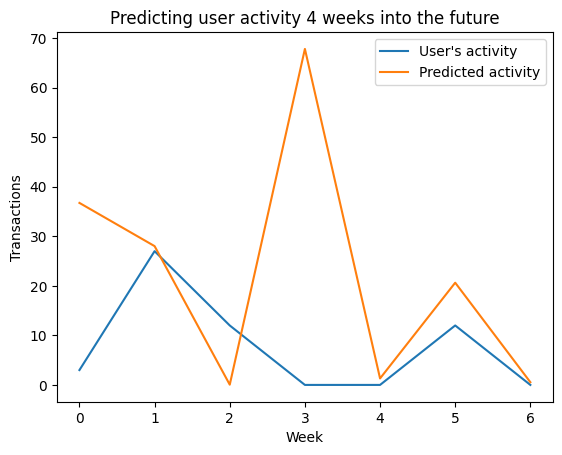

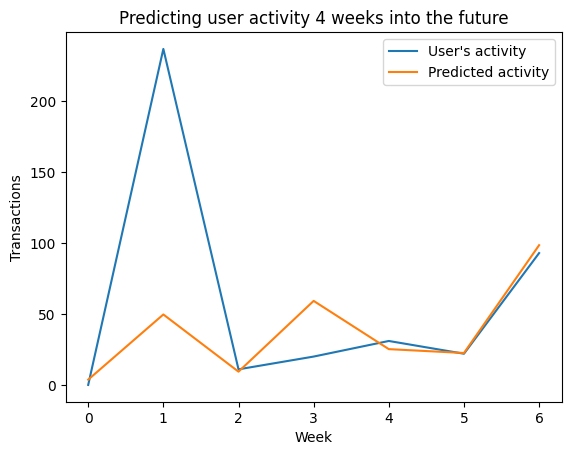

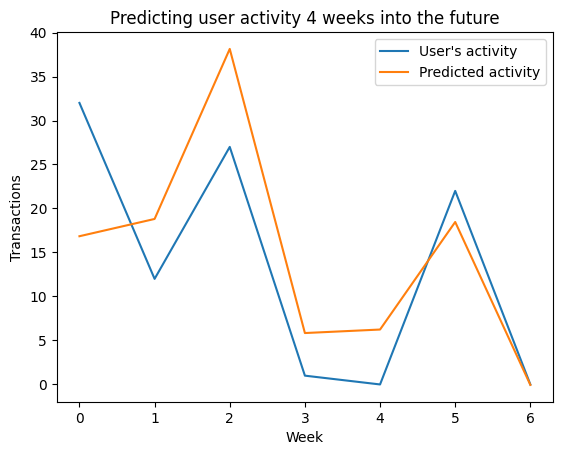

In [ ]:
for user in range(0, 12*5, 12):
    plt.figure()
    plt.title("Predicting user activity 4 weeks into the future")
    plt.xlabel("Week")
    plt.ylabel("Transactions")
    sns.lineplot(x=range(7), y=y_test[user].flatten(), label="User's activity")
    sns.lineplot(x=range(7), y=y[user].flatten(), label="Predicted activity")

    plt.plot()
